In [27]:
# Source: https://pyimagesearch.com/2020/06/22/turning-any-cnn-image-classifier-into-an-object-detector-with-keras-tensorflow-and-opencv/

In [28]:
import numpy as np
import pandas as pd
import cv2
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
import time

In [29]:
def sliding_window(image, step, ws):
    for y in range(0, image.shape[0] - ws[1], step):
        for x in range(0, image.shape[1] - ws[0], step):
            yield (x, y, image[y:y+ws[1], x:x+ws[0]])

In [30]:
def image_pyramid(image, scale=1.5, min_size=(224,224)):
    yield image
    
    while True:
        w = int(image.shape[0] / scale)
        h = int(image.shape[1] / scale)
        image = cv2.resize(image, (w, h))
        
        if image.shape[0] <= min_size[0] or image.shape[1] <= min_size[1]:
            break
            
        yield image

In [31]:
def preprocess_input(image, input_size):
    image = cv2.resize(image, input_size)
    image = keras.preprocessing.image.img_to_array(image)
    return keras.applications.resnet.preprocess_input(image)

In [32]:
target = cv2.imread("/kaggle/input/dataset-1/LUX7417-1_desktop.jpg")
target = target[...,::-1]
(orig_w, orig_h) = target.shape[:2]

In [33]:
model = keras.applications.ResNet50(weights="imagenet", include_top=True)
# rois = np.array(rois, dtype="float32")
# preds = model.predict(rois)

In [34]:
STEP = 50
WINDOW_SIZE = (500,500)
INPUT_SIZE = (224,224)
MIN_PROB = 0.8

raw_preds = []
boxes = []
for image in image_pyramid(target):
    scale = orig_w / image.shape[0]
    
    for (x, y, roi_image) in sliding_window(image, STEP, WINDOW_SIZE):
        x = int(x * scale)
        y = int(y * scale)
        w = int(WINDOW_SIZE[0] * scale)
        h = int(WINDOW_SIZE[1] * scale)
        box = (x, y, x+w, y+h)
        
        roi_image_pred = preprocess_input(roi_image, INPUT_SIZE)
        roi_image_pred = np.array([roi_image_pred], dtype="float32")
        
        raw_preds.append(model.predict(roi_image_pred)[0])
        boxes.append(box)
        
raw_preds = np.array(raw_preds, dtype="float32")

aaaaaaaaaaaa
1/1 [==============================] - 0s 24ms/step
aaaaaaaaaaaa
1/1 [==============================] - 0s 24ms/step
aaaaaaaaaaaa
aaaaaaaaaaaa


In [35]:
decoded_preds = keras.applications.imagenet_utils.decode_predictions(raw_preds, top=1)

formated_preds = []
for i, decoded_pred in enumerate(decoded_preds):
    (imagenetID, label, prob) = decoded_pred[0]
    if prob < MIN_PROB:
        continue

    formated_pred = {
        "box": boxes[i],
        "label": label,
        "prob": prob,
    }
    formated_preds.append(formated_pred)
    
formated_preds

[{'box': (850, 0, 1350, 500), 'label': 'minivan', 'prob': 0.8904385},
 {'box': (900, 0, 1400, 500), 'label': 'minivan', 'prob': 0.8636641},
 {'box': (950, 0, 1450, 500), 'label': 'minivan', 'prob': 0.9743173},
 {'box': (1000, 0, 1500, 500), 'label': 'minivan', 'prob': 0.94555026},
 {'box': (1050, 0, 1550, 500), 'label': 'minivan', 'prob': 0.8234262},
 {'box': (1100, 0, 1600, 500), 'label': 'minivan', 'prob': 0.8473114},
 {'box': (1150, 0, 1650, 500), 'label': 'minivan', 'prob': 0.8782901},
 {'box': (1200, 0, 1700, 500), 'label': 'minivan', 'prob': 0.8889061},
 {'box': (950, 50, 1450, 550), 'label': 'minivan', 'prob': 0.86972535},
 {'box': (850, 200, 1350, 700), 'label': 'car_wheel', 'prob': 0.8227003},
 {'box': (950, 250, 1450, 750), 'label': 'car_wheel', 'prob': 0.82275796},
 {'box': (150, 300, 650, 800), 'label': 'grille', 'prob': 0.8011442},
 {'box': (950, 300, 1450, 800), 'label': 'car_wheel', 'prob': 0.8020154},
 {'box': (126, 126, 547, 547), 'label': 'pickup', 'prob': 0.8726191},

dict_keys(['minivan', 'car_wheel', 'grille', 'pickup'])


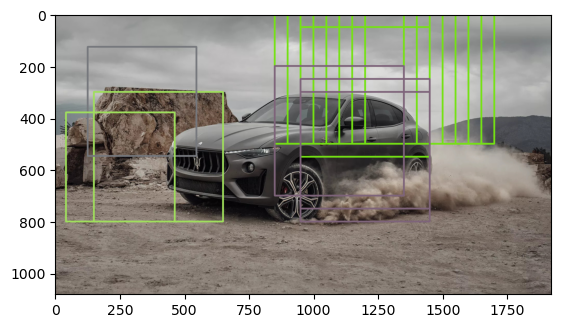

In [36]:
from random import randint

clone = target.copy()
label_color = {}
for pred in formated_preds:
    box = pred["box"]
    label = pred["label"]
    prob = pred["prob"]
    
    if label not in label_color:
        label_color[label] = (randint(0, 255), randint(0, 255), randint(0, 255))
        
    x = box[0]
    y = box[1]
    xx = box[2]
    yy = box[3]
    
#     print(x, y, xx, yy)
    cv2.rectangle(clone, (x, y), (xx, yy), label_color[label], 5)
    
print(label_color.keys())
plt.imshow(clone)